# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev1 toc-item"><a href="#Solving-the-system-of-differential-equations" data-toc-modified-id="Solving-the-system-of-differential-equations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Solving the system of differential equations</a></div><div class="lev1 toc-item"><a href="#Looking-at-the-evolution-of-the-phase" data-toc-modified-id="Looking-at-the-evolution-of-the-phase-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Looking at the evolution of the phase</a></div><div class="lev2 toc-item"><a href="#Showing-the-phases-moving-around-the-circle" data-toc-modified-id="Showing-the-phases-moving-around-the-circle-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Showing the phases moving around the circle</a></div><div class="lev1 toc-item"><a href="#How-does-the-final-coherence-depend-on-the-coupling-strength-K?" data-toc-modified-id="How-does-the-final-coherence-depend-on-the-coupling-strength-K?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>How does the final coherence depend on the coupling strength K?</a></div><div class="lev2 toc-item"><a href="#Finding-the-value-of-K-that-leads-to-the-highest-synchronization" data-toc-modified-id="Finding-the-value-of-K-that-leads-to-the-highest-synchronization-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Finding the value of K that leads to the highest synchronization</a></div>

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import Image
from scipy.interpolate import interp1d
import json

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Solving-the-system-of-differential-equations" data-toc-modified-id="Solving-the-system-of-differential-equations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Solving the system of differential equations</a></span></li><li><span><a href="#Looking-at-the-evolution-of-the-phase" data-toc-modified-id="Looking-at-the-evolution-of-the-phase-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Looking at the evolution of the phase</a></span><ul class="toc-item"><li><span><a href="#Showing-the-phases-moving-around-the-circle" data-toc-modified-id="Showing-the-phases-moving-around-the-circle-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Showing the phases moving around the circle</a></span></li></ul></li><li><span><a href="#How-does-the-final-coherence-depend-on-the-coupling-strength-K?" data-toc-modified-id="How-does-the-final-coherence-depend-on-the-coupling-strength-K?-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>How does the final coherence depend on the coupling strength K?</a></span><ul class="toc-item"><li><span><a href="#Finding-the-value-of-K-that-leads-to-the-highest-synchronization" data-toc-modified-id="Finding-the-value-of-K-that-leads-to-the-highest-synchronization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Finding the value of K that leads to the highest synchronization</a></span></li></ul></li></ul></div>

# Introduction

After having read Steven H. Strogatz' book _Sync: The Emerging Science of Spontaneous Order_ my interest in spontaneous synchronization was spiked. One reason for this is the fact that I am currently analyzing electrocardiograms at work, and one of the examples in the book of the syncrhonization (or lack thereof) is the heart and the dangerouse arytmia that can come out of nowhere.

The aim of this notebook is to reproduce the results reported by Steven H. Strogatz and Renato E. Mirollo in 1991. It contains a simulation of the Kuramoto model, which should exhibbit some of the same charactertistics as the pacemaker cells in the heat.

# Solving the system of differential equations

The system of differential equations to be solved is:

$
 \dot\theta_i = \omega_i + \frac{K}{N} \sum\limits_{j=1}^{N} \sin \left( \theta_j - \theta_i \right)
$

Here $\theta_i$ is the phase of the _ith_ oscillator, $\omega_i$ is its natural frequency, and $K\geq0$ is the coupling strength.

The statement i want to reproduce is the following:

> The system (1.1) was studied for the case of N=480 oscillators, with
coupling strength $K=1$. The frequencies were uniformly distributed on $[-\gamma, \gamma]$, where $\gamma=0.2$. There was no noise, i.e., $D=0$. The goal was to simulate the evolution of the system starting near the incoherent solution. For these parameters, equation (3.15b) predicts that the coherence $r(t)$ should initially grow exponentially at a rate $\alpha \approx 0.47304$.

How exactely is the coherence ($r(t)$) defined?

Along the way I will make some additional figures and simulations to make sense of the results.

Below I define the functions that set up the initial conditions and calculates the time derivative of the phase for each oscillator, as described above.

In [2]:
def set_up_initial_conditions(N=800):
    omega = np.random.uniform(-0.2, 0.2, N)
    theta = np.random.uniform(0, 2, N)*np.pi
    return omega, theta


def calc_theta_dot(omega, theta, N, K):
    theta_dot = np.zeros((N,))
    for i in range(N):
        theta_dot[i] = omega[i] + (K/N)*np.sum(np.sin(theta-theta[i]))
    return theta_dot

Lets have a look at an example of initial conditions created in this manner:

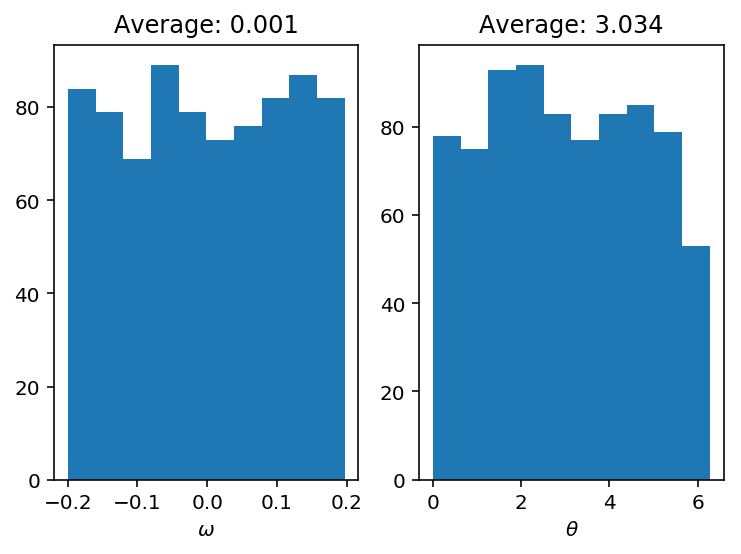

In [3]:
omega, theta = set_up_initial_conditions()

fig, ax = plt.subplots(ncols=2)
ax[0].hist(omega)
ax[1].hist(theta)

ax[0].set_title('Average: {0:.3f}'.format(np.average(omega)))
ax[1].set_title('Average: {0:.3f}'.format(np.average(theta)))

ax[0].set_xlabel(r"$\omega$")
ax[1].set_xlabel(r"$\theta$");

Below I define two house-keeping function that simply add labels to figures that will be needed several times.

In [4]:
def add_labels(ax, K):
    ax.set_ylabel(r"$\theta$")
    ax.set_xlabel("Time steps")

    yticks = [0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]
    yticks_labels = [r"0", r"$\frac{\pi}{2}$",
                     r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]

    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks_labels)

    ax.set_title("K={0}".format(K))


def add_relaxation_labels(ax):
    ax.set_ylabel(r"$Var(\theta)$")
    ax.set_xlabel(r"Time steps")
    #ax.set_ylim([0, 1])

With that out of the way, lets look at how the simulation is run.

In [5]:
def run_simulation(omega, theta, N=480, K=1, STEPS=25):
    thetas = np.zeros((N, STEPS))
    for i in range(STEPS):
        theta_dot = calc_theta_dot(omega, theta, N=N, K=K)
        theta = np.mod(theta_dot + theta, 2*np.pi)
        thetas[:, i] = theta
    return thetas

The function takes the initial values as inputs as well as parameteres for the simulation: The number of oscillators, their coupling strength and the number of iteration steps the simulation run over. Below I run the simulation.

In [6]:
STEPS = 100
K = 1
N = 480
omega, theta = set_up_initial_conditions(N=N)
thetas = run_simulation(omega, theta, N=N, K=K, STEPS=STEPS)

# Looking at the evolution of the phase

Now a simulation has been run, let's have a look at the results. Since we looking fir synchronization it makes sense to look at how the phase of each oscillator evolves over time. 

## Showing the phases moving around the circle
In the book Stogatz asks the reader to think of each spring as a runner on a track. The runners influence each others speed. If Synch arises, this would mean that the runners end up running around the track bundled up in a group. Lets visualize the simulation like this -- the phase of each oscillator will be converted to (x,y) points on a circle.

I have made the points transparrent so it the clumping up becomes more aparrent. 

In [7]:
%%capture
# This line is here to supress the output of a empty fiure
rc('animation', html='html5')
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim((-1.1, 1.1))
ax.set_ylim((-1.1, 1.1))
ax.set_axis_off()

dots, = ax.plot([], [], 'ob', alpha=0.2)


def init():
    dots.set_data([], [])
    return (dots,)


def animate(i):
    x, y = np.cos(thetas[:, i]), np.sin(thetas[:, i])
    dots.set_data(x, y)
    ax.set_title('Step: {0}'.format(i))
    return (dots,)


anim = FuncAnimation(fig, animate, init_func=init,
                     frames=thetas.shape[1], interval=200)

To show the animation in the notebook on GitHub, I need to save it as a .gif file and include it. This is done below.

In [8]:
!brew install imagemagick

Error: imagemagick 7.0.7-21 is already installed
To upgrade to 7.0.8-14, run `brew upgrade imagemagick`


In [9]:
anim.save('animation.gif', writer='imagemagick', fps=3)

In [10]:
Image(url='animation.gif')

While this animation above is interesting, it would be nice to quantize the results some more. Below I show the phase of each oscillator for each time step together with the average phase of all the oscillators. This figures illustrates how the oscillators fall into synchronization. 

To get an idea about how _fast_ the system gets synchronized I have also plotted the variance of the phases as a function of simulation time step. It clearly shows an initial exponential drop in the variance as it levels off at some value.

The plateau value shows the level of synchronization reached by the system and the initial exponential decay shows the at with the synchronization is reached.

Saving the data so I can use it for animations in d3

In [11]:
np.savetxt('animation_data_theta.csv',
           np.transpose(thetas),
           delimiter=',',
           fmt='%10.10f',
           header=",".join(["osc"+str(i) for i in range(N)]))

I need to structure the data as JSON.

In [12]:
thetas.shape

(480, 100)

In [13]:
json_data = {
    "steps": [
        {"thetas": [{"theta": theta, "newAngle": theta} for theta in thetas[:,i]]}
    for i in range(thetas.shape[1]) ] 
}

with open('../../data/animation_data_theta.json', 'w') as fp:
    json.dump(json_data, fp)

In [14]:
A = thetas.reshape((STEPS, N))
A.shape

(100, 480)

Continuing the analysis

In [15]:
def get_halfway_point(x, y):
    f2 = interp1d(x, y, kind='linear')
    return f2(0.5)

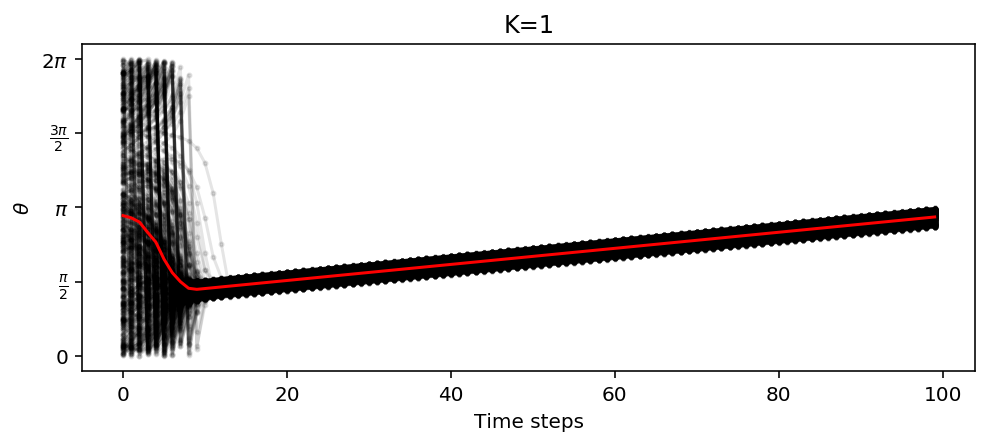

In [16]:
fig, ax = plt.subplots(figsize=(8, 3))
for i in range(thetas.shape[0]):
    ax.plot(range(STEPS), thetas[i, :], '-ok', alpha=0.1, markersize=2)

avg = np.average(thetas, axis=0)
ax.plot(range(STEPS), avg, '-r')
add_labels(ax, K)

In [17]:
thetas.shape

(480, 100)

In [18]:
json_data = {
    "oscillators": [
        {"osc": [{"step": step, "theta": theta} for step, theta in enumerate(thetas[osc_id, :])]}
    for osc_id in range(thetas.shape[0]) 
    ] 
}

with open('../../data/angle-vs-time.json', 'w') as fp:
    json.dump(json_data, fp)

Text(0, 0.5, 'Var($\\theta$)')

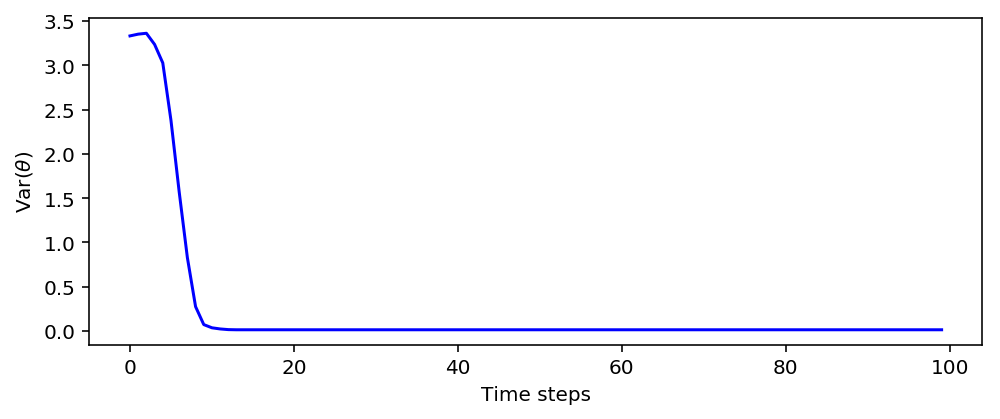

In [19]:
fig, ax = plt.subplots(figsize=(8, 3))
var = np.var(thetas, axis=0)
ax.plot(range(STEPS), var, '-b')
ax.set_xlabel('Time steps')
ax.set_ylabel(r'Var($\theta$)')
ax.set_ylabel(r'Var($\theta$)')

In [20]:
json_data = {
    "data": [
        {"step":step, 'var_theta': var_theta }
    for step, var_theta in  zip(range(STEPS), var)
    ]
}
with open('../../data/theta-vs-time.json', 'w') as fp:
    json.dump(json_data, fp)

Text(0, 0.5, 'Normalized Var($\\theta$)')

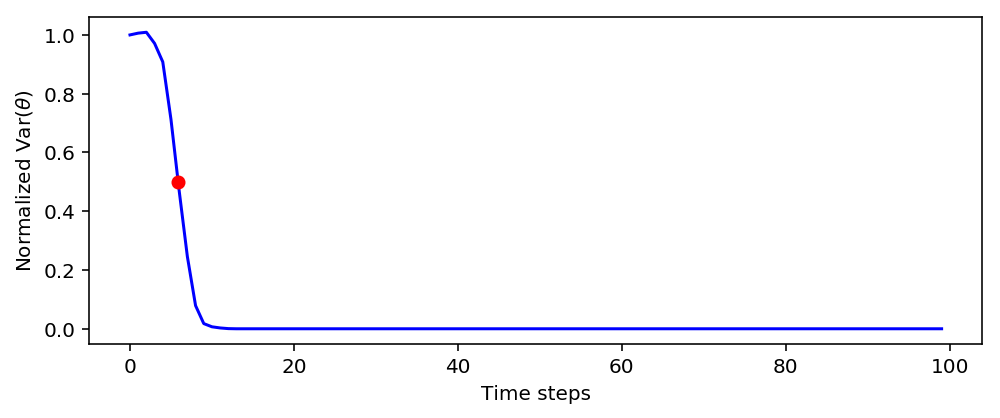

In [21]:
fig, ax = plt.subplots(figsize=(8, 3))
var_norm = (var[-1]-var)/(var[-1]-var[0])
ax.plot(range(STEPS), var_norm, '-b')
hwp = get_halfway_point(var_norm, range(STEPS))
ax.plot(hwp, 0.5, 'ro')
ax.set_xlabel('Time steps')
ax.set_ylabel(r'Normalized Var($\theta$)')

In [22]:
json_data = {
    "data": [
        {"step":step, 'var_theta': var_theta }
    for step, var_theta in  zip(range(STEPS), var_norm)
    ],
    'midpoint': {'step': float(hwp), 'var_theta':0.5}
}
with open('../../data/normalized-theta-vs-time.json', 'w') as fp:
    json.dump(json_data, fp)

Text(0, 0.5, 'Normalized Var($\\theta$)')

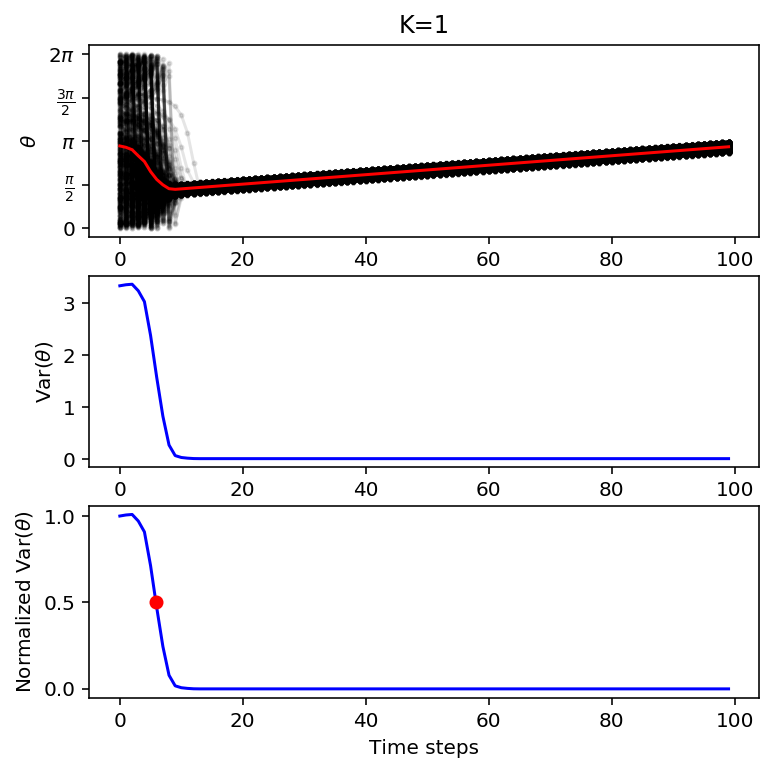

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(6, 6))
for i in range(thetas.shape[0]):
    ax[0].plot(range(STEPS), thetas[i, :], '-ok', alpha=0.1, markersize=2)

avg = np.average(thetas, axis=0)
ax[0].plot(range(STEPS), avg, '-r')
add_labels(ax[0], K)

var = np.var(thetas, axis=0)
ax[1].plot(range(STEPS), var, '-b')
ax[1].set_xlabel('Time steps')
ax[1].set_ylabel(r'Var($\theta$)')

var_norm = (var[-1]-var)/(var[-1]-var[0])
ax[2].plot(range(STEPS), var_norm, '-b')
hwp = get_halfway_point(var_norm, range(STEPS))
ax[2].plot(hwp, 0.5, 'ro')
ax[2].set_xlabel('Time steps')
ax[2].set_ylabel(r'Normalized Var($\theta$)')

Because the preferred frequency of each oscillator uniformly distributed between -0.2 and 0.2 the oscillators often end up in a fairly stable stable situation where the phase does not change much over time.

# How does the final coherence depend on the coupling strength K?
Above I showed how we can characterize the level of synchronization that is reached as well as the speed at which it is reached. So lets run the simulation for different values of $K$ and look at how this influence the synchronization level and synchronization time.

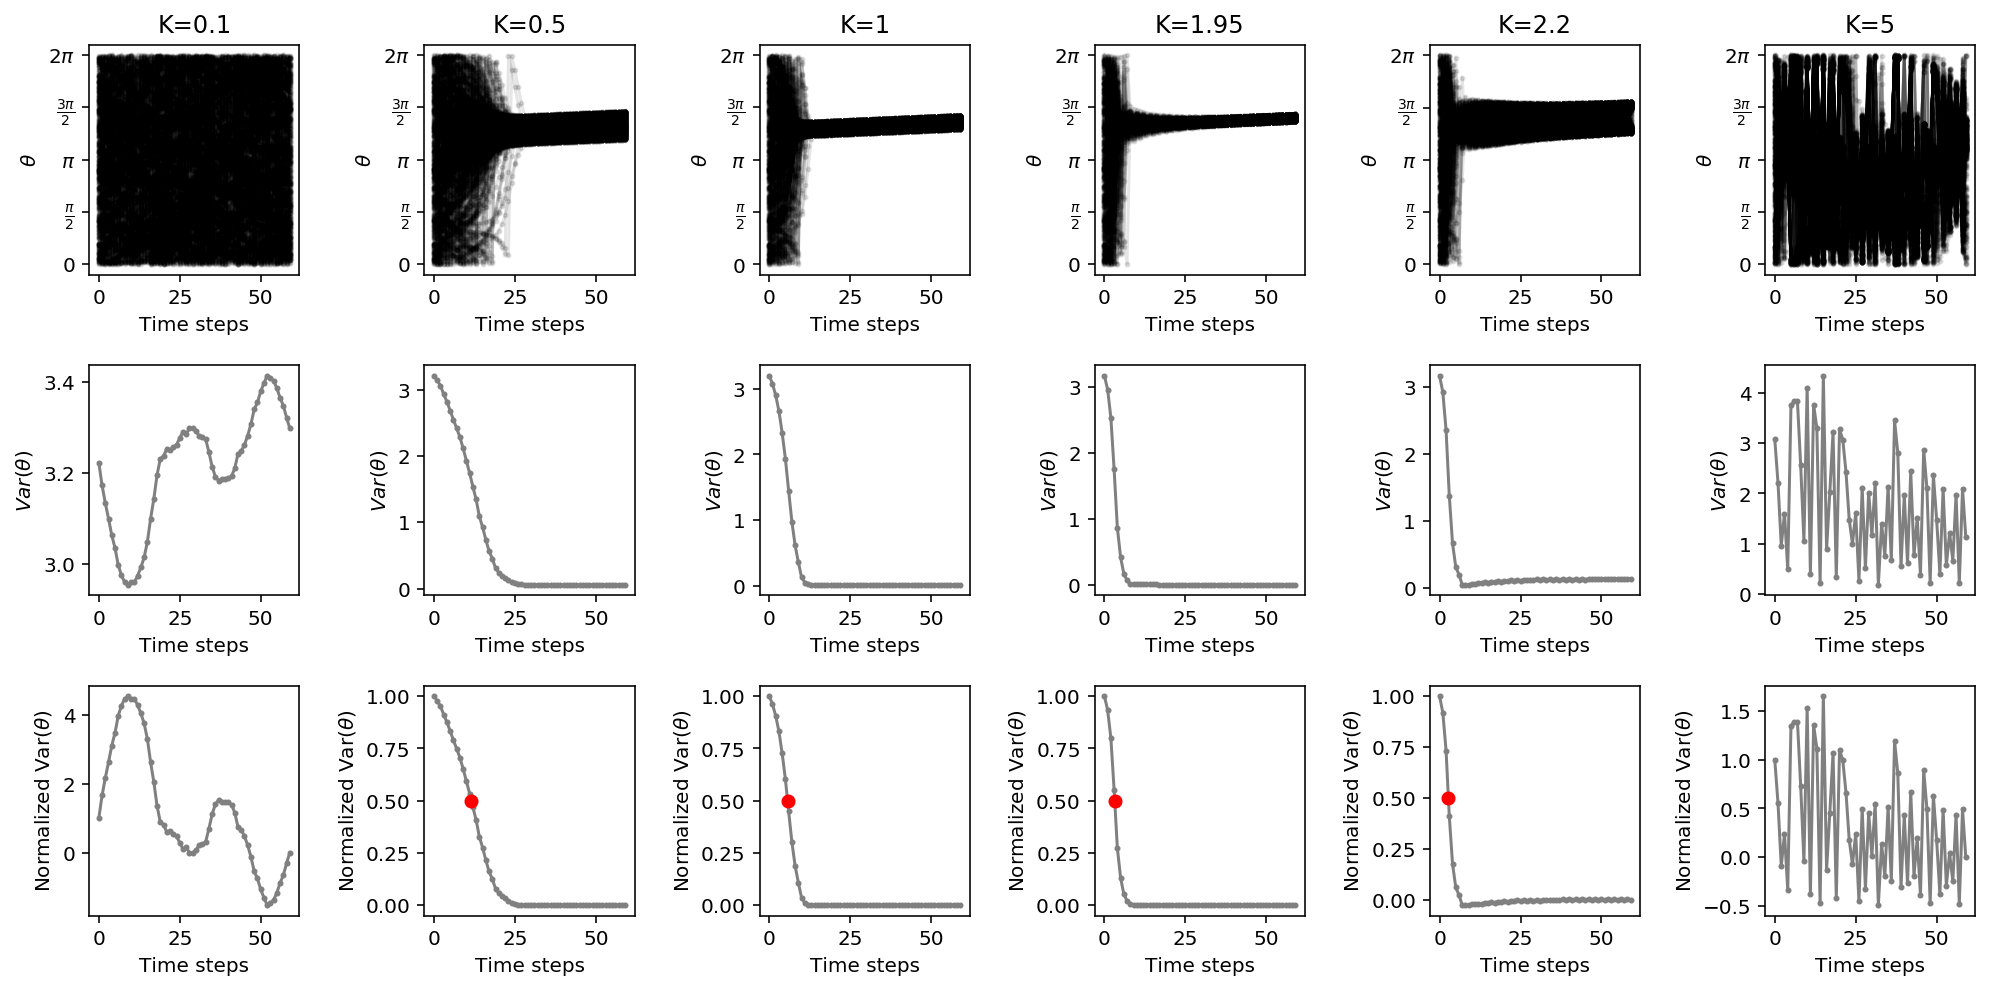

In [24]:
fig, axes = plt.subplots(ncols=6, nrows=3, figsize=(14, 7))
initial_omega, initial_theta = set_up_initial_conditions(N=480)
STEPS = 60
Ks = [0.1, 0.5, 1, 1.95, 2.2, 5]
all_thetas = []
all_normalized_variances = []
all_halfwaypoints = []
for idx, K in enumerate(Ks):
    omega, theta = initial_omega, initial_theta
    thetas = run_simulation(omega, theta, N=480, STEPS=STEPS, K=K)
    
    for i in range(thetas.shape[0]):
        axes[0, idx].plot(range(STEPS), thetas[i, :],
                          '-ok', alpha=0.1, markersize=2)
        add_labels(axes[0, idx], K)

    var = np.var(thetas, axis=0)
    axes[1, idx].plot(range(STEPS), var, '-o', color='grey', markersize=2)
    add_relaxation_labels(axes[1, idx])

    var_norm = (var[-1]-var)/(var[-1]-var[0])
    axes[2, idx].plot(range(STEPS), var_norm, '-o', color='grey', markersize=2)
    if var[-1] < 0.25:
        hwp = get_halfway_point(var_norm[:25], range(STEPS)[:25])
        axes[2, idx].plot(hwp, 0.5, 'ro')
    axes[2, idx].set_xlabel('Time steps')
    axes[2, idx].set_ylabel(r'Normalized Var($\theta$)')
    
    # Saving the results
    all_thetas.append(thetas)
    all_normalized_variances.append(var_norm)
    all_halfwaypoints.append(float(hwp))

fig.tight_layout()

If you preferred to look at the points as they run around the circle, then here you go

In [32]:
json_data = {
    "oscillators": [
        {"osc": [{"step": step, "theta": theta} for step, theta in enumerate(thetas[osc_id, :])]}
    for osc_id in range(thetas.shape[0]) 
    ] 
}


In [36]:
json_data=[
    {
        'K':K,
        'circleSimulation': [
            {"thetas":
              [
                {"theta":theta, "newAngle": theta} for theta in thetas[:,i]
              ]
            }
        for i in range(thetas.shape[1])],
        "thetaVsTime": {
            "oscillators": [
                {"osc": [{"step": step, "theta": theta} 
                     for step, theta in enumerate(thetas[osc_id, :])]}
                for osc_id in range(thetas.shape[0])]
        },
        "normThetaVsTime": {
            'curve': [
                {"step":step, 'var_theta': var_theta }
            for step, var_theta in  zip(range(STEPS), var_norm)
            ],
            'midpoint': {'step': float(hwp), 'var_theta':0.5}
        }
        
    }
    for K, thetas, var_norm, hwp in zip(Ks, all_thetas, all_normalized_variances, all_halfwaypoints)];

with open('../../data/k_comparison.json', 'w') as fp:
    json.dump(json_data, fp)

In [ ]:
%%capture
# This line is here to supress the output of a empty figure
rc('animation', html='html5')
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(14, 2.2))
for ax, K in zip(axes, Ks):
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))
    ax.set_title('K = {0}'.format(K))
    ax.set_axis_off()

In [ ]:
all_dots = []
for ax in axes:
    dots, = ax.plot([], [], 'ob', alpha=0.2)
    all_dots.append(dots)


def init():
    for idx in range(len(axes)):
        dots = all_dots[idx]
        dots.set_data([], [])
    return (dots,)


def animate(i):
    for ax_idx, ax, thetas in zip(range(len(axes)), axes, all_thetas):
        x, y = np.cos(thetas[:, i]), np.sin(thetas[:, i])
        dots = all_dots[ax_idx]
        dots.set_data(x, y)
        ax.set_xlabel('Step: {0}'.format(i))
    return (dots,)


anim = FuncAnimation(fig, animate, init_func=init,
                     frames=thetas.shape[1], interval=200)

In [ ]:
anim.save('animation_varying_k.gif', writer='imagemagick', fps=3)

## Finding the value of K that leads to the highest synchronization
Above we saw that coupling strength influence how synchronized the oscillators end up being -- to low or too high no synchronization will take place. In between there seem to be a sweet spot, so is there an optimal value? Lets check.

In [ ]:
STEPS = 50
N = 480
Ks = np.arange(0, 3.01, 0.01)
variances = np.zeros((len(Ks), STEPS))
end_variances = np.zeros((len(Ks), ))

synchronization_Ks = []
synchronization_times = []


initial_omega, initial_theta = set_up_initial_conditions(N=N)
for idx, K in enumerate(Ks):
    omega, theta = initial_omega, initial_theta
    thetas = run_simulation(omega, theta, N=N, STEPS=STEPS, K=K)

    var = np.var(thetas, axis=0)
    variances[idx, :] = np.var(thetas, axis=0)
    end_variances[idx] = np.var(thetas[:, -1])

    var_norm = (var[-1]-var)/(var[-1]-var[0])
    if var[-1] < 0.25:
        synchronization_times.append(get_halfway_point(var_norm, range(STEPS)))
        synchronization_Ks.append(K)

synchronization_times = np.array(synchronization_times)
synchronization_Ks = np.array(synchronization_Ks)

All the simulations were started with the same initial conditions, so only the coupling strengths were changed.

In [ ]:
lowest_variance = np.min(end_variances)
K_at_lowest_variance = Ks[np.where(end_variances == lowest_variance)][0]

lowest_synchronization_time = np.min(synchronization_times)
K_at_lowest_synchronization_times = synchronization_Ks[
    np.where(synchronization_times == lowest_synchronization_time)
][0]

fig, ax = plt.subplots(nrows=2, figsize=(6, 7))

ax[0].plot(Ks, np.log10(end_variances), '-ob')
ax[0].set_title("Minumum final phase: {1:.4f} at K = {0:.2f}".format(
    K_at_lowest_variance, lowest_variance))
ax[0].set_ylabel(r'$\log_{10}$ of final $\theta$')

ax[1].plot(synchronization_Ks, synchronization_times, 'or-')
ax[1].set_title("Minumum relaxation time {1:.4f} at K = {0:.2f}".format(
                K_at_lowest_synchronization_times, lowest_synchronization_time
                )
                )

ax[1].set_xlim([0, 3])
ax[1].set_xlabel('K')
ax[1].set_ylabel(r'Synchonization time')

In [ ]:
json_data = {
    "data": [
        {"K":K,
         'endVariance': end_variance,
        }
    for K, end_variance in  zip(Ks, np.log10(end_variances))
    ]
}
with open('../../data/endVarianceVsK.json', 'w') as fp:
    json.dump(json_data, fp)

In [ ]:
json_data = {
    "data": [
        {"K":K,
         'synchTime': synch_time,
        }
    for K, synch_time in  zip(synchronization_Ks, synchronization_times)
    ]
}
with open('../../data/synchTimeVsK.json', 'w') as fp:
    json.dump(json_data, fp)

So it would appear that a coupling close to $K\approx1.95$ leads to the lowest variance in the final phase reached by the oscillators in the simulation. The synchronization time continues to drop even after the final phase has reached its minimum, but after $K=\approx 2.3$ the system no longer syncronizes.

### Conclusion
We have seen that a collection of coupled oscillators set up with a uniform distribution of preferred oscillation frequencies can end up all oscillating with a frequency close to each other.

We have shows how the evolution of the system can be characterized by two numbers, and look at how these numbers correlate. We have also discussed how the two numbers can be used as operational values -- answering the question how should I set the parameters of the system to reach the highest level of synchronization, or to get the shortest time to a synchronized state.